In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import gc
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, Dense, LSTM, TimeDistributed
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model

In [3]:
BATCH_SIZE = 40
NUM_EPOCHS = 10
EMBEDDING_DIM = 50
LSTM_NODES = 128


In [4]:
decoder_inp = open('/content/gdrive/My Drive/20k_decoder_inp.txt', 'r', encoding='utf-8',
                  errors='ignore').read().split('\n')
decoder_out = open('/content/gdrive/My Drive/20k_decoder_out.txt', 'r', encoding='utf-8',
                  errors='ignore').read().split('\n')

encoder_inp =open('/content/gdrive/My Drive/20k_encoder_inp.txt', 'r', encoding='utf-8',
                  errors='ignore').read().split('\n')

full_text = encoder_inp + decoder_inp + decoder_out

In [5]:
tokenizer = Tokenizer(filters='', oov_token='<UNK>')
tokenizer.fit_on_texts(full_text)
word_index=tokenizer.word_index

In [6]:
encoder_sequences = tokenizer.texts_to_sequences(encoder_inp)
decoder_inp_sequences = tokenizer.texts_to_sequences(decoder_inp)
decoder_out_sequences = tokenizer.texts_to_sequences(decoder_out)

In [8]:
del(full_text)

In [7]:
max_len_ques = max([len(x) for x in encoder_sequences])
max_len_answ = max([len(y) for y in decoder_inp_sequences])

print(max_len_ques, max_len_answ)

218 174


In [9]:
VOCAB_SIZE = len(word_index)+1
VOCAB_SIZE

12672

In [10]:
index2word = {}
word2index = {}
for k,v in word_index.items():
    if v < VOCAB_SIZE:
        index2word[v] = k
    if v > VOCAB_SIZE:
        continue
    
for k,v in index2word.items():
    word2index[v] = k

len(word2index) == len(index2word)

True

In [ ]:
embed_dict = {}

with open('/content/gdrive/My Drive/glove.6B.50d.txt', 'r', encoding='utf-8',
                  errors='ignore') as f:
    for line in f:
      records = line.split()
      word = records[0]
      vector = np.asarray(records[1:], dtype='float32')
      embed_dict[word] = vector

embed_mat = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, idx in word2index.items():
  embed_vect = embed_dict.get(word)
  if embed_vect is not None:
    embed_mat[idx] = embed_vect

In [ ]:
del(embed_dict)

In [11]:
def generate_batch(enc_data, dec_inp_data, dec_out_data):
  num_batches = len(enc_data)// BATCH_SIZE
  print(num_batches)
  while True:
    for idxint in range(0, len(enc_data), num_batches):
      start = idxint
      end = idxint+num_batches

      encoder_input_data = pad_sequences(enc_data[start:end], maxlen = max_len_ques, dtype='int32',
                                      padding='post', truncating='post')
      decoder_input_data = pad_sequences(dec_inp_data[start:end], maxlen =max_len_answ, dtype='int32',
                                      padding='post', truncating='post')
      
      decoder_output_data = to_categorical(pad_sequences(dec_out_data[start:end], maxlen =max_len_answ, dtype='int32',
                                      padding='post', truncating='post'), num_classes=VOCAB_SIZE)
      yield [encoder_input_data, decoder_input_data], decoder_output_data
      gc.collect()


In [ ]:
def seq2seq_model_builder(HIDDEN_DIM=EMBEDDING_DIM, LSTM_DIM=LSTM_NODES):
    
    encoder_inputs = Input(shape=(max_len_ques, ), dtype='int32',)
    encoder_embedding = Embedding(VOCAB_SIZE,HIDDEN_DIM, weights=[embed_mat], mask_zero=True)(encoder_inputs)
    encoder_LSTM = LSTM(LSTM_DIM, return_state=True)
    encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)
    encoder_states = [state_h, state_c]
    
    decoder_inputs = Input(shape=(max_len_answ, ), dtype='int32',)
    decoder_embedding = Embedding(VOCAB_SIZE, LSTM_DIM, trainable=True, mask_zero=True)(decoder_inputs)
    decoder_LSTM = LSTM(LSTM_DIM, return_state=True, return_sequences=True)
    decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=encoder_states)
    
    decoder_outputs = TimeDistributed(Dense(VOCAB_SIZE, activation='softmax'))(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    return model

In [ ]:
model = seq2seq_model_builder()

In [ ]:
model.compile(optimizer='adam', loss ='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 218)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 174)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 218, 50)      633600      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 174, 128)     1622016     input_2[0][0]                    
______________________________________________________________________________________________

In [12]:
model = load_model('/content/gdrive/My Drive/chatbot6.h5')

In [ ]:
model.compile(optimizer='adam', loss ='categorical_crossentropy', metrics = ['accuracy'])

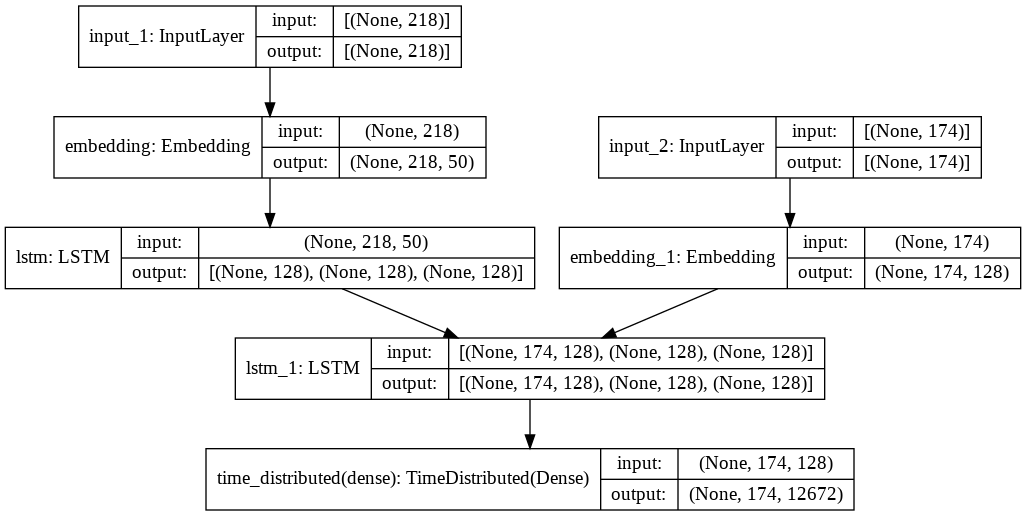

In [13]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [14]:
history = model.fit(generate_batch(encoder_sequences, decoder_inp_sequences, decoder_out_sequences),
                              steps_per_epoch = len(encoder_sequences)//10,
                              epochs = 1,
                              max_queue_size=1, workers=0)
    

235
 18/942 [..............................] - ETA: 32:07 - loss: 0.0671 - accuracy: 0.7856

KeyboardInterrupt: ignored

In [15]:
model.save('/content/gdrive/My Drive/chatbot6.h5')

In [17]:
del(model)

In [ ]:

model.save('/content/gdrive/My Drive/saved_model/cbot_model4')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/saved_model/cbot_model4/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/saved_model/cbot_model4/assets


In [15]:
import pickle

In [16]:
with open('/content/gdrive/My Drive/tokenizer6.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
q_a_lens = {'max_len_ques' : max_len_ques, 'max_len_answ' : max_len_answ}

In [18]:
with open('/content/gdrive/My Drive/input_output_shapes6.pickle','wb') as temp:
  pickle.dump(q_a_lens, temp)

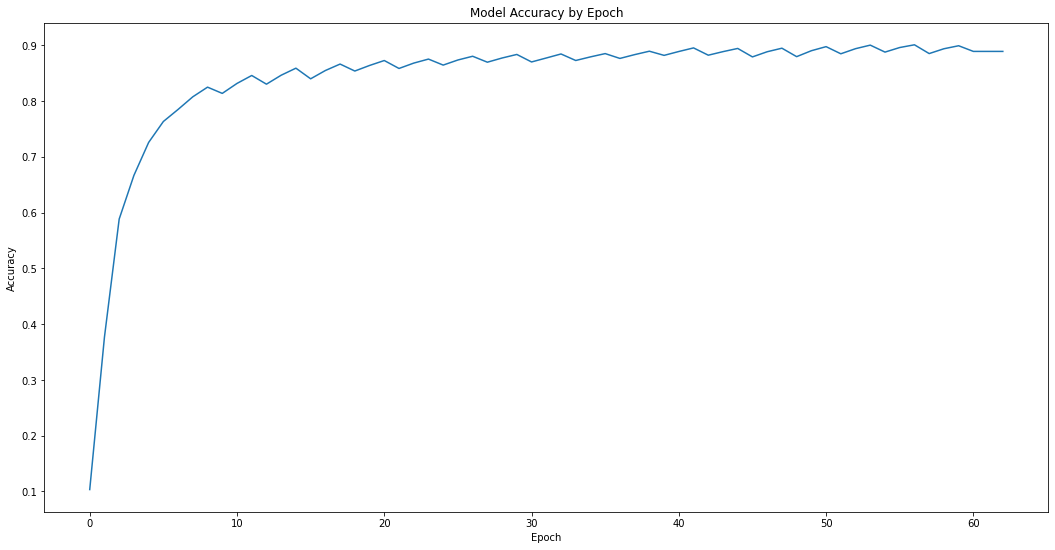

In [ ]:
plt.subplots(1,1,figsize=(18,9))
plt.plot(acc_list)
plt.title('Model Accuracy by Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
from tensorflow.keras.models import save_model